In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from astropy.time import Time
import warnings
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator

In [70]:
import sys
sys.path.append('../tools/')
from dust_extinction import calALambda
from data_binning import data_binning
from visual import rcparams_format

rcparams_format(mpl.rcParams)

color_map = {
    'cyan': '#66c2a5',
    'orange': '#ff7f00',
    'blue': '#8da0cb',
    'b': '#1f77b4',
    'purple': '#7570b3',
    'pink': '#fccde5',
    'green': '#33a02c',
    'yellow': '#ffd92f',
    'brown': '#e5c494',
    'magenta': '#f1598a',
    'grey': '0.3',
    'darkgrey': '0.2',
    'palegrey': '0.6'
}

In [19]:
print('NumPy version: {}'.format(np.__version__))
print('pandas version: {}'.format(pd.__version__))
print('matplotlib version: {}'.format(mpl.__version__))

NumPy version: 1.22.4
pandas version: 1.4.2
matplotlib version: 3.5.2


In [20]:
#%matplotlib notebook

In [21]:
# SN metadata

z = 0.0307
t_max = 2458986.91
t_max_mjd = t_max - 2400000.5
ebv = 0.404
rv = 3.1

tfl = 58972.46296299994

In [22]:
def plot_box_spec(wave, flux):
    flux_plot = np.repeat(flux, 2)
    wv_plot = wave.copy()
    wv_plot[:-1] += np.diff(wave) / 2
    wv_plot = np.append(
        wave[0] - (wave[1] - wave[0]) / 2,
        np.append(np.repeat(wv_plot[0:-1], 2),
                  wave[-1] + (wave[-1] - wave[-2]) / 2))

    return wv_plot, flux_plot

In [23]:
spec_files = glob.glob('./SN2020jgb/ZTF20aayhacx*.ascii')
spec_files.sort()

In [24]:
spec_files

['./SN2020jgb/ZTF20aayhacx_20200507_P60_v2.ascii',
 './SN2020jgb/ZTF20aayhacx_20200513_NOT_v4.ascii',
 './SN2020jgb/ZTF20aayhacx_20200521_P60_v2.ascii',
 './SN2020jgb/ZTF20aayhacx_20200528_P60_v2.ascii',
 './SN2020jgb/ZTF20aayhacx_20200529_Lick_3-m_v1.ascii',
 './SN2020jgb/ZTF20aayhacx_20200608_P60_v2.ascii',
 './SN2020jgb/ZTF20aayhacx_20200609_Gemini-N_v1.ascii',
 './SN2020jgb/ZTF20aayhacx_20200610_P200_v2.ascii',
 './SN2020jgb/ZTF20aayhacx_20200623_Keck1_v1.ascii',
 './SN2020jgb/ZTF20aayhacx_20200915_Keck1_sub.ascii',
 './SN2020jgb/ZTF20aayhacx_20200915_Keck1_v2.ascii',
 './SN2020jgb/ZTF20aayhacx_20201020_Keck1_sub.ascii',
 './SN2020jgb/ZTF20aayhacx_20201020_Keck1_v1.ascii']

In [25]:
# SN metadata


class SN_meta:
    def __init__(self, name, z, tmax, ebv, files, IR_thres=1.1e4):
        self.name = name
        self.z = z
        self.t_max_mjd = tmax - 2400000.5
        self.ebv = ebv
        files = np.sort(files)
        self.NIRfiles = files[[(np.loadtxt(spec)[-1, 0] > IR_thres)
                               for spec in files]]
        self.NIRfiles = self.NIRfiles[[
            not ('GNIRS_v' in spec) for spec in self.NIRfiles
        ]]
        self.OPTfiles = files[[(np.loadtxt(spec)[-1, 0] < IR_thres)
                               for spec in files]]
        print(self.NIRfiles)


jgb = SN_meta('SN\ 2020jgb',
              z=0.0307,
              tmax=2458986.91,
              ebv=0.404,
              files=glob.glob('./SN2020jgb/*ascii'))
byg = SN_meta('SN\ 2018byg',
              z=0.066,
              tmax=2458257.7, #2458258.99,
              ebv=0.032,
              files=glob.glob('./SN2018byg/ZTF18aaqeasu*ascii'))
hnk = SN_meta('SN\ 2016hnk',
              z=0.0161,
              tmax=2457689.98,
              ebv=0.0224,
              files=glob.glob('./SN2016hnk/*dat'))
fe = SN_meta('SN\ 2011fe',
             z=0.000804,
             tmax=2455814.27,
             ebv=0.008,
             files=glob.glob('./SN2011fe/*dat'))
da = SN_meta('SN\ 2004da',
             z=0.015881,
             tmax=2453189.7,
             ebv=0.109,
             files=glob.glob('./SN2004da/*flm'))

['./SN2020jgb/ZTF20aayhacx_20200609_Gemini-N_v1.ascii']
['./SN2018byg/ZTF18aaqeasu_20180603_Keck1_v1.ascii']
['./SN2016hnk/2016hnk_2016-11-04_01-57-23.700_Gemini-S_Flamingos-2_PESSTO.dat'
 './SN2016hnk/2016hnk_2016-11-06_02-05-03.429_ESO-NTT_Sofi_PESSTO.dat']
['./SN2011fe/SN2011fe_2011-08-28_04-05-00_HST_STIS_HST-Ia.dat'
 './SN2011fe/SN2011fe_2011-08-31_06-00-00_HST_STIS_HST-Ia.dat'
 './SN2011fe/SN2011fe_2011-09-03_09-07-00_HST_STIS_HST-Ia.dat'
 './SN2011fe/SN2011fe_2011-09-07_08-53-00_HST_STIS_HST-Ia.dat'
 './SN2011fe/SN2011fe_2011-09-10_09-22-00_HST_STIS_HST-Ia.dat'
 './SN2011fe/SN2011fe_2011-09-13_16-05-00_HST_STIS_HST-Ia.dat']
[]


5438.8 12000
0 12000
4467.1 12000
4416.0 12000
4064.0 10124.0
5413.2 12000
4340.189368362706 12000
3584.9308000000005 9999.240511111111
4592.7330999999995 8510.513666666666
./SN2020jgb/ZTF20aayhacx_20200915_Keck1_v2.ascii
4592.457700000001 8500.908755555556
./SN2020jgb/ZTF20aayhacx_20201020_Keck1_v1.ascii


/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_61576/2206239737.py:34: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_61576/2206239737.py:34: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")


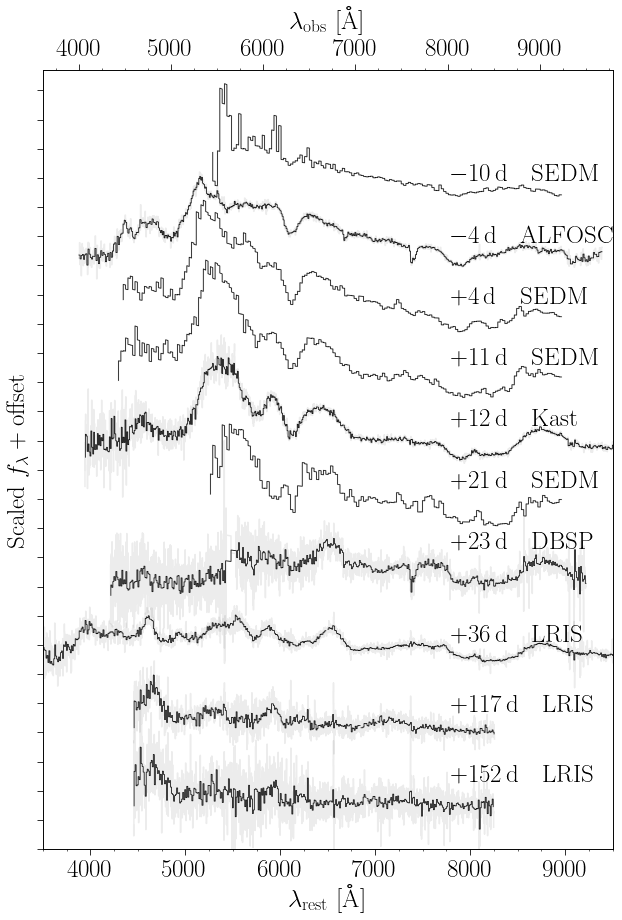

In [26]:
ebv = 0.404

fig, ax = plt.subplots(figsize=(8.5, 12))
spec_num = 0
mjd_list = []
for spec in spec_files:
    if 'Gemini' in spec:
        continue
    if 'Keck' in spec:
        instru = 'LRIS'
    elif 'P60' in spec:
        instru = 'SEDM'
    elif 'P200' in spec:
        instru = 'DBSP'
    elif 'Lick' in spec:
        instru = 'Kast'
    elif 'NOT' in spec:
        instru = 'ALFOSC'
    instru = '\mathrm{' + instru + '}'
    spec_df = pd.read_csv(spec,
                          comment='#',
                          delim_whitespace=True,
                          header=None)

    try:
        if 'Keck' in spec:
            fl_unc = spec_df[3].values
        else:
            fl_unc = spec_df[2].values

            if 'P60' in spec or 'P200' in spec:
                fl_unc **= .5
    except:
        warnings.warn("No flux uncertainty in the datafile!")
        # set relative uncertainty to be 10%
        fl_unc = np.ones_like(spec_df[0].values) * 1e-1 * np.median(
            spec_df[0].values)
    with open(spec) as f:
        ll = f.readlines()
    # brute force
    mjd_found = False
    for l in ll:
        if 'MJD' in l:
            mjd_found = True
            if '=' in l and 'at start' in l:
                mjd_obs = float(l.split('=')[1].split("'")[1])
            elif '=' in l and '/' in l:
                mjd_obs = float(l.split('=')[1].split('/')[0])
            elif '=' in l:
                mjd_obs = float(l.split('=')[1])
            elif ':' in l:
                mjd_obs = float(l.split(':')[1])
            break
    if not mjd_found:
        print('Warning: MJD-obs not found in {}!'.format(spec))
        print('Try the observation date.')
        year = '_2020'
        pos_dat = spec.find(str(year)) + 1
        year_obs = spec[pos_dat:pos_dat + 4]
        mon_obs = spec[pos_dat + 4:pos_dat + 6]
        date_obs = spec[pos_dat + 6:pos_dat + 8]
        mjd_obs = Time('{}-{}-{}'.format(year_obs, mon_obs, date_obs)).mjd

    phase = (mjd_obs - t_max_mjd) / (1 + z)
    if ((phase > 100) and (not 'sub' in spec)):
        print(spec)
        continue
    spec_num += 1
    mjd_list = np.append(mjd_list, mjd_obs)
    if mjd_obs < t_max_mjd + 30:
        if mjd_obs < t_max_mjd:
            ax.text(
                7800, 1 - 2.1 * spec_num,
                r'$-{:.0f}\,\mathrm d\quad {}$'.format(np.abs(phase), instru))
        else:
            ax.text(
                7800, 1 - 2.1 * spec_num,
                r'$+{:.0f}\,\mathrm d\quad {}$'.format(np.abs(phase), instru))
    else:
        ax.text(7800, 2.3 - 2.4 * spec_num,
                r'$+{:.0f}\,\mathrm d\quad {}$'.format(np.abs(phase), instru))
    fl_unc0 = fl_unc.copy()

    out = data_binning(np.array([spec_df[0].values, spec_df[1].values,
                                 fl_unc]).T,
                       size=10)

    wv, fl = plot_box_spec(out[:, 0], out[:, 1])
    wv0, fl0 = plot_box_spec(spec_df[0].values, spec_df[1].values)

    fl_unc = np.repeat(out[:, -1], 2)
    fl_unc0 = np.repeat(fl_unc0, 2)
    
    
    if 'P60' in spec: 
        snr = 2.5
        bl, rd = 5500, 9000
    elif phase > 30:
        snr = 1
        bl, rd = 4600, 8500
    else:
        snr = 2.5
        bl, rd = 5500, 9000
    try:
        wv_cut0 = out[np.where(~((out[:, 0] >= bl)
                                 | (out[:, 1] >= out[:, 2] * snr)))[0][-1], 0]
    except IndexError:
        wv_cut0 = 0
    fl = fl[wv > wv_cut0]
    fl_unc = fl_unc[wv > wv_cut0]
    wv = wv[wv > wv_cut0]
    try:
        wv_cut1 = out[np.where(~((out[:, 0] <= rd)
                                 | (out[:, 1] >= out[:, 2] * snr)))[0][0], 0]
    except IndexError:
        wv_cut1 = 12000
    fl = fl[wv < wv_cut1]
    fl_unc = fl_unc[wv < wv_cut1]
    wv = wv[wv < wv_cut1]
    E = 10**(0.4 * calALambda(wv, rv, ebv))
    fl *= E
    if phase > 30:
        norm_flux = np.nanmax(fl[np.where((wv > 4600) & (wv < 4800))]) / 2
    else:
        norm_flux = np.nanmedian(fl[np.where((wv > 7500) & (wv < 7700))])
    if phase < 30:
        ax.plot(wv / (1 + z),
                fl / norm_flux - 2.2 * spec_num,
                color='k',
                linewidth=0.8)
    else:
        ax.plot(wv / (1 + z),
                fl / norm_flux - 2.25 * spec_num,
                color='k',
                linewidth=0.8)
    arg = (wv0 > wv_cut0) & (wv0 < wv_cut1)
    print(wv_cut0, wv_cut1)
    E0 = 10**(0.4 * calALambda(wv0, rv, ebv))
    if phase > 30:
        ax.plot(
            wv0[arg] / (1 + z),
            (fl0 * E0)[arg] / norm_flux - 2.25 * spec_num,
            color='grey',  ##aam_colors['blue'],
            alpha=0.15)
    else:
        ax.plot(
            wv0[arg] / (1 + z),
            (fl0 * E0)[arg] / norm_flux - 2.2 * spec_num,
            color='grey',  ##aam_colors['blue'],
            alpha=0.15)

ax.set_xlim(3500, 9500)
ax.set_ylim(-24, 2.7)
ax.set_yticklabels([])
ax.set_ylabel(r'$\mathrm{Scaled}\ f_\lambda + \mathrm{offset}$')
ax.set_xlabel(r'$\lambda_\mathrm{rest}\ [\mathrm{\r{A}}]$',
              **{'fontname': 'Times New Roman'})
ax.xaxis.set_minor_locator(MultipleLocator(250))
ax.yaxis.set_major_locator(MultipleLocator(1))

wv_obs = ax.twiny()
wv_obs.set_xlim(np.array(ax.get_xlim()) * (1 + z))
wv_obs.set_xlabel(r'$\lambda_\mathrm{obs}\ [\mathrm{\r{A}}]$', labelpad=10)
wv_obs.xaxis.set_minor_locator(MultipleLocator(250))

fig.subplots_adjust(left=0.06, bottom=0.051, top=0.953, right=0.991)
#fig.savefig('../paper/figures/optical_spec_evolution.pdf', bbox_inches='tight')

/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_61576/589996576.py:33: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_61576/589996576.py:33: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_61576/589996576.py:213: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_61576/589996576.py:213: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")


./SN2020jgb/ZTF20aayhacx_20200915_Keck1_v2.ascii
./SN2020jgb/ZTF20aayhacx_20201020_Keck1_v1.ascii


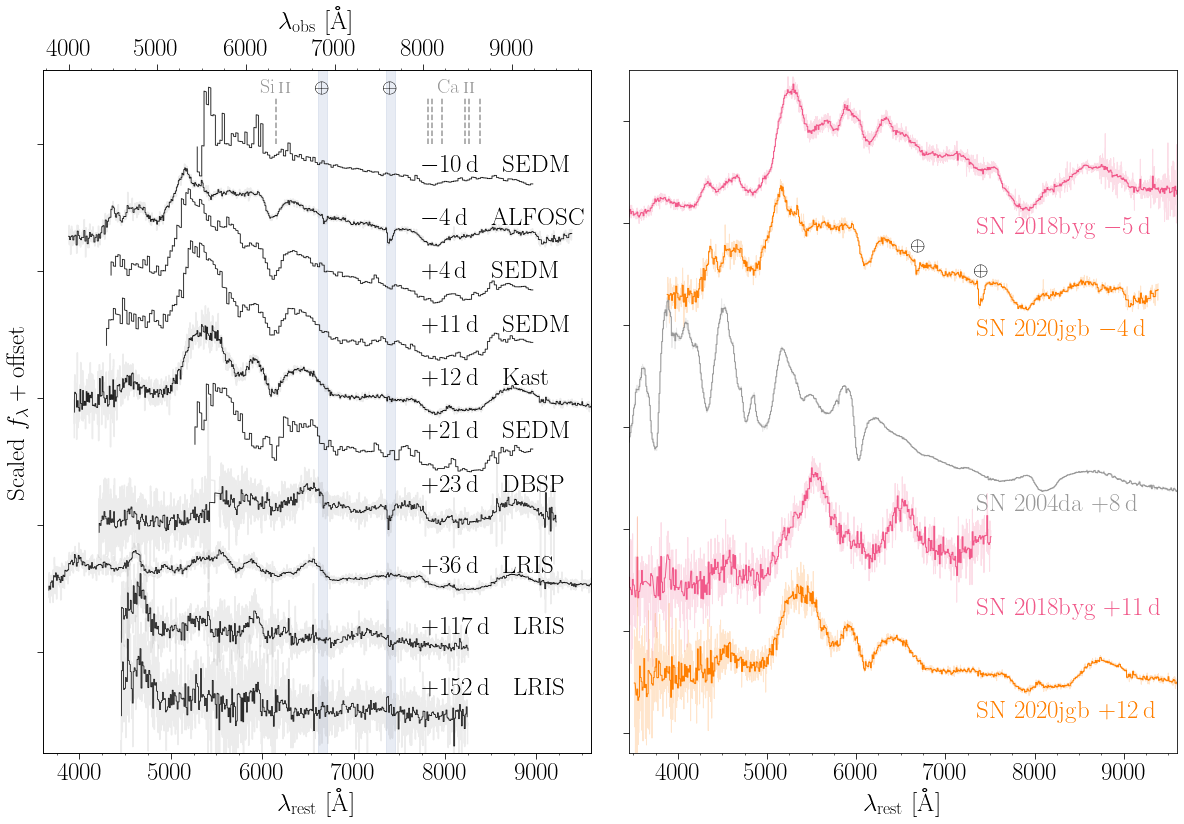

In [71]:
ebv = 0.404

fig, ax = plt.subplots(1, 2, figsize=(17, 12))
spec_num = 0
for spec in spec_files:
    if 'Gemini' in spec:
        continue
    if 'Keck' in spec:
        instru = 'LRIS'
    elif 'P60' in spec:
        instru = 'SEDM'
    elif 'P200' in spec:
        instru = 'DBSP'
    elif 'Lick' in spec:
        instru = 'Kast'
    elif 'NOT' in spec:
        instru = 'ALFOSC'
    instru = '\mathrm{' + instru + '}'
    spec_df = pd.read_csv(spec,
                          comment='#',
                          delim_whitespace=True,
                          header=None)

    try:
        if 'Keck' in spec:
            fl_unc = spec_df[3].values
        else:
            fl_unc = spec_df[2].values

            if 'P60' in spec or 'P200' in spec:
                fl_unc **= .5
    except:
        warnings.warn("No flux uncertainty in the datafile!")
        # set relative uncertainty to be 10%
        fl_unc = np.ones_like(spec_df[0].values) * 1e-1 * np.median(
            spec_df[0].values)
    with open(spec) as f:
        ll = f.readlines()
    # brute force
    mjd_found = False
    for l in ll:
        if 'MJD' in l:
            mjd_found = True
            if '=' in l and 'at start' in l:
                mjd_obs = float(l.split('=')[1].split("'")[1])
            elif '=' in l and '/' in l:
                mjd_obs = float(l.split('=')[1].split('/')[0])
            elif '=' in l:
                mjd_obs = float(l.split('=')[1])
            elif ':' in l:
                mjd_obs = float(l.split(':')[1])
            break
    if not mjd_found:
        print('Warning: MJD-obs not found in {}!'.format(spec))
        print('Try the observation date.')
        year = '_2020'
        pos_dat = spec.find(str(year)) + 1
        year_obs = spec[pos_dat:pos_dat + 4]
        mon_obs = spec[pos_dat + 4:pos_dat + 6]
        date_obs = spec[pos_dat + 6:pos_dat + 8]
        mjd_obs = Time('{}-{}-{}'.format(year_obs, mon_obs, date_obs)).mjd

    phase = (mjd_obs - t_max_mjd) / (1 + z)
    if ((phase > 100) and (not 'sub' in spec)):
        print(spec)
        continue
    spec_num += 1
    if mjd_obs < t_max_mjd + 30:
        if mjd_obs < t_max_mjd:
            ax[0].text(7750,
                       1 - 2.1 * spec_num,
                       r'$-{:.0f}\,\mathrm d\quad {}$'.format(
                           np.abs(phase), instru),
                       fontsize=25)
        else:
            ax[0].text(7750,
                       1 - 2.1 * spec_num,
                       r'$+{:.0f}\,\mathrm d\quad {}$'.format(
                           np.abs(phase), instru),
                       fontsize=25)
    else:
        ax[0].text(7750,
                   2.3 - 2.4 * spec_num,
                   r'$+{:.0f}\,\mathrm d\quad {}$'.format(
                       np.abs(phase), instru),
                   fontsize=25)
    fl_unc0 = fl_unc.copy()

    out = data_binning(np.array([spec_df[0].values, spec_df[1].values,
                                 fl_unc]).T,
                       size=10)

    wv, fl = plot_box_spec(out[:, 0], out[:, 1])
    wv0, fl0 = plot_box_spec(spec_df[0].values, spec_df[1].values)

    fl_unc = np.repeat(out[:, -1], 2)
    fl_unc0 = np.repeat(fl_unc0, 2)

    if phase > 30:
        snr = 2.5
        bl, rd = 4600, 8500
    else:
        snr = 2.5
        bl, rd = 5500, 9000
    try:
        wv_cut0 = out[np.where(~((out[:, 0] >= bl)
                                 | (out[:, 1] >= out[:, 2] * snr)))[0][-1], 0]
    except IndexError:
        wv_cut0 = 0
    fl = fl[wv > wv_cut0]
    fl_unc = fl_unc[wv > wv_cut0]
    wv = wv[wv > wv_cut0]
    try:
        wv_cut1 = out[np.where(~((out[:, 0] <= rd)
                                 | (out[:, 1] >= out[:, 2] * snr)))[0][0], 0]
    except IndexError:
        wv_cut1 = 12000
    fl = fl[wv < wv_cut1]
    fl_unc = fl_unc[wv < wv_cut1]
    wv = wv[wv < wv_cut1]
    E = 10**(0.4 * calALambda(wv, rv, ebv))
    fl *= E
    if phase > 100:
        norm_flux = np.nanmax(fl[np.where((wv > 4600) & (wv < 4800))]) / 3
    else:
        norm_flux = np.nanmedian(fl[np.where((wv > 7500) & (wv < 7700))])
    if phase < 30:
        ax[0].plot(wv / (1 + z),
                   fl / norm_flux - 2.2 * spec_num,
                   color='k',
                   linewidth=0.8)
    else:
        ax[0].plot(wv / (1 + z),
                   fl / norm_flux - 2.25 * spec_num,
                   color='k',
                   linewidth=0.8)
    arg = (wv0 > wv_cut0) & (wv0 < wv_cut1)
    E0 = 10**(0.4 * calALambda(wv0, rv, ebv))
    if phase > 30:
        ax[0].plot(
            wv0[arg] / (1 + z),
            (fl0 * E0)[arg] / norm_flux - 2.25 * spec_num,
            color='grey',  ##aam_colors['blue'],
            alpha=0.15)
    else:
        ax[0].plot(
            wv0[arg] / (1 + z),
            (fl0 * E0)[arg] / norm_flux - 2.2 * spec_num,
            color='grey',  ##aam_colors['blue'],
            alpha=0.15)

h = 1.0
v = 7350

num = -1
k = -1
for sn, c in zip([byg, jgb, da, byg, jgb],
                 ['magenta', 'orange', 'palegrey', 'magenta', 'orange']):
    k += 1
    for spec in sn.OPTfiles:
        if 'P60' in spec:  #don't use SEDM
            continue
        spec_df = pd.read_csv(spec,
                              comment='#',
                              delim_whitespace=True,
                              header=None)

        with open(spec) as f:
            ll = f.readlines()
        # brute force
        mjd_found = False
        for l in ll:
            if 'MJD' in l:
                mjd_found = True
                if '=' in l and 'at start' in l:
                    mjd_obs = float(l.split('=')[1].split("'")[1])
                elif '=' in l and '/' in l:
                    mjd_obs = float(l.split('=')[1].split('/')[0])
                elif '=' in l:
                    try:
                        mjd_obs = float(l.split('=')[1])
                    except:
                        mjd_obs = float(l.split('=')[1].split('\'')[1])
                elif ':' in l:
                    mjd_obs = float(l.split(':')[1])
                break
        if not mjd_found:
            continue

        phase = (mjd_obs - sn.t_max_mjd) / (1 + sn.z)
        if k == 0 and phase > -4:
            continue
        if k < 3 and ((phase < -5) or (phase > 9)):
            continue
        if k == 3 and ((phase < 9) or (phase > 15)):
            continue
        if k == 4 and ((phase < 10) or (phase > 12)):
            continue
        num += 1
        if (sn == da) and (phase < 8):
            num -= 0.3
            continue

        try:
            if 'Keck' in spec:
                fl_unc = spec_df[3].values
            else:
                fl_unc = spec_df[2].values

                if 'P60' in spec or 'P200' in spec:
                    fl_unc **= .5
        except:
            warnings.warn("No flux uncertainty in the datafile!")
            # set relative uncertainty to be 10%
            fl_unc = np.ones_like(spec_df[0].values) * 1e-1 * np.median(
                spec_df[0].values)
        fl_unc0 = fl_unc.copy()

        wv0, fl0 = spec_df[0].values, spec_df[1].values,
        E0 = 10**(0.4 * calALambda(wv0, rv, sn.ebv))
        fl0 = fl0 * E0

        out = data_binning(np.array(
            [spec_df[0].values, spec_df[1].values, fl_unc]).T,
                           size=10)
        wv, fl = plot_box_spec(out[:, 0], out[:, 1])
        wv, fl = wv[fl > 1e-2 * np.nanmedian(fl)], fl[fl > 1e-2 *
                                                      np.nanmedian(fl)]

        fl_unc = np.repeat(out[:, -1], 2)

        E = 10**(0.4 * calALambda(wv, rv, sn.ebv))
        fl = fl * E

        norm_flux = np.nanmedian(fl[np.where((wv / (1 + sn.z) > 5200)
                                             & (wv / (1 + sn.z) < 5700))])
        ax[1].plot(wv0 / (1 + sn.z), (fl0 / norm_flux) - h * num,
                   color=color_map[c],
                   linewidth=1,
                   alpha=0.2)
        ax[1].plot(wv / (1 + sn.z), (fl / norm_flux) - h * num,
                   color=color_map[c],
                   linewidth=1)
        if mjd_obs < sn.t_max_mjd:
            ax[1].text(min(v, wv[-1] / (1 + sn.z) * 1.01),
                       -.1 * h - 1.01 * h * num,
                       r'$\mathrm{' + sn.name + '}$' +
                       ' $-{:.0f}\,\mathrm d$'.format(np.abs(phase)),
                       color=color_map[c],
                       fontsize=25)
        else:
            ax[1].text(min(v, wv[-1] / (1 + sn.z) * 1.01),
                       -.1 * h - 1.01 * h * num,
                       r'$\mathrm{' + sn.name + '}$' +
                       ' $+{:.0f}\,\mathrm d$'.format(np.abs(phase)),
                       color=color_map[c],
                       fontsize=25)

ax[0].text(7633 / (1 + z), 2.0, r'$\oplus$', ha='center', fontsize=20)
ax[0].text(6867 / (1 + z), 2.0, r'$\oplus$', ha='center', fontsize=20)

ax[0].fill_between([7633 / (1 + z) - 50, 7633 / (1 + z) + 50], [-24, -24],
                   [3, 3],
                   color=color_map['blue'],
                   alpha=0.2)
ax[0].fill_between([6867 / (1 + z) - 50, 6867 / (1 + z) + 50], [-24, -24],
                   [3, 3],
                   color=color_map['blue'],
                   alpha=0.2)
# Ca ii and Si ii lines
C = 299792.458
dlam_lam = lambda v: ((1 - v / C) / (1 + v / C))**.5
param_dic = {'linestyle': '--', 'color': '0.6', 'zorder': -10}
ax[0].text(s=r'$\mathrm{Si}\,\textsc{ii}$',
           x=6355 * dlam_lam(10000),
           y=2,
           fontsize=20,
           color='0.6',
           ha='center')
ax[0].plot([6355 * dlam_lam(10000), 6355 * dlam_lam(10000)], [0, 1.8],
           **param_dic)
ax[0].text(s=r'$\mathrm{Ca}\,\textsc{ii}$',
           x=8542 * dlam_lam(15000),
           y=2,
           fontsize=20,
           color='0.6',
           ha='center')
ax[0].plot([8498 * dlam_lam(25000), 8498 * dlam_lam(25000)], [0, 1.8],
           **param_dic)
ax[0].plot([8542 * dlam_lam(25000), 8542 * dlam_lam(25000)], [0, 1.8],
           **param_dic)
ax[0].plot([8662 * dlam_lam(25000), 8662 * dlam_lam(25000)], [0, 1.8],
           **param_dic)
ax[0].plot([8498 * dlam_lam(10000), 8498 * dlam_lam(10000)], [0, 1.8],
           **param_dic)
ax[0].plot([8542 * dlam_lam(10000), 8542 * dlam_lam(10000)], [0, 1.8],
           **param_dic)
ax[0].plot([8662 * dlam_lam(10000), 8662 * dlam_lam(10000)], [0, 1.8],
           **param_dic)

ax[0].set_xlim(3600, 9600)
ax[0].set_yticklabels([])
ax[0].set_ylabel(r'$\mathrm{Scaled}\ f_\lambda + \mathrm{offset}$')
ax[0].set_xlabel(r'$\lambda_\mathrm{rest}\ [\mathrm{\r{A}}]$')
ax[0].xaxis.set_minor_locator(MultipleLocator(250))
#ax[0].yaxis.set_major_locator(MultipleLocator(1))

ax[1].set_xlim(3450, 9600)
ax[0].set_ylim(-24, 2.9)
ax[0].set_xticks(np.arange(4, 10) * 1000)
ax[1].set_xticks(np.arange(4, 10) * 1000)
ax[1].set_ylim(-h * (num + .5), h * 1.5)
ax[1].set_yticklabels([])
ax[1].set_ylabel('')
ax[1].set_xlabel(r'$\lambda_\mathrm{rest}\ [\mathrm{\r{A}}]$',
                 **{'fontname': 'Times New Roman'})
ax[1].xaxis.set_minor_locator(MultipleLocator(250))

ax[1].text(7633 / (1 + z) + 5, -0.52, r'$\oplus$', ha='center', fontsize=20)
ax[1].text(6867 / (1 + z) + 40, -0.27, r'$\oplus$', ha='center', fontsize=20)
#ax[1].yaxis.set_major_locator(MultipleLocator(1))

#fig.subplots_adjust(left=0.06, bottom=0.051, top=0.953, right=0.991)
#fig.savefig('../paper/figures/NIR_spec_comp.pdf', bbox_inches='tight')

wv_obs = ax[0].twiny()
wv_obs.set_xlim(np.array(ax[0].get_xlim()) * (1 + z))
wv_obs.set_xticks(np.arange(4, 10) * 1000)
wv_obs.set_xlabel(r'$\lambda_\mathrm{obs}\ [\mathrm{\r{A}}]$', labelpad=10)
wv_obs.xaxis.set_minor_locator(MultipleLocator(250))

fig.subplots_adjust(left=0.06, bottom=0.051, top=0.953, right=0.991)
fig.tight_layout()
fig.savefig('../paper/figures/optical_spec_evolution.pdf', bbox_inches='tight')

# Line Velocity

In [28]:
date_list = (np.array(mjd_list)-t_max_mjd) / (1 + z)

In [29]:
SiII_vel = np.array([
    np.nan, -11737, -11356, -11528, -11239, -10461, np.nan, np.nan,
    np.nan, np.nan
])
SiII_vel_sig = np.array(
    [np.nan, 73, 85, 200, 75, 207, np.nan, np.nan, np.nan, np.nan])

CaII_vel_pvf = np.array([
    -15330, -11179, -9762, -8795, -9401, -9103, -9572, -9569, np.nan,
    np.nan
])
CaII_vel_pvf_sig = np.array(
    [120, 228, 212, 969, 128, 588, 464, 147, np.nan, np.nan])

CaII_vel_hvf = np.array([
    -25884, -24218, -24171, -24001, -24584, -24161, -23590, -23841,
    np.nan, np.nan
])
CaII_vel_hvf_sig = np.array(
    [247, 106, 296, 1130, 114, 691, 474, 151, np.nan, np.nan])

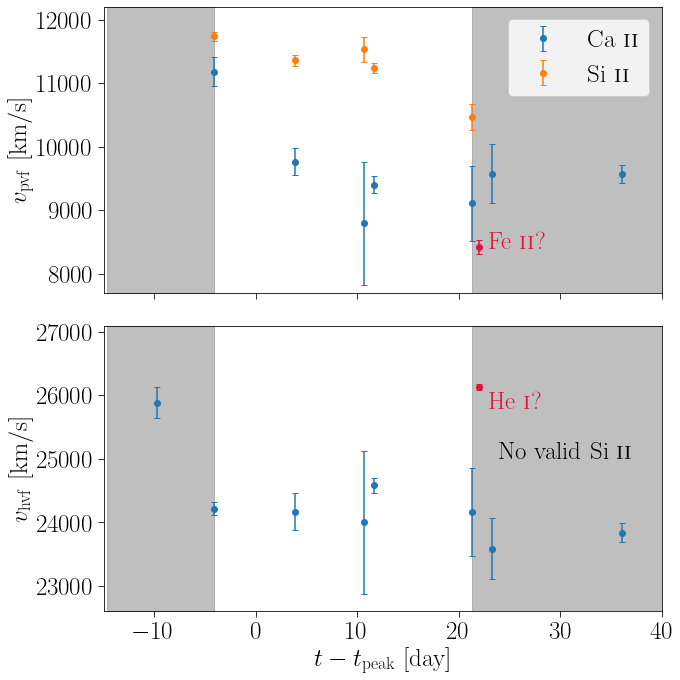

In [30]:
f, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

ylim1 = [7700, 12200]
ylim2 = [22600, 27100]

ax[0].errorbar(date_list,
               -CaII_vel_pvf,
               yerr=CaII_vel_pvf_sig,
               fmt='o',
               capsize=3,
               label=r'$\mathrm{Ca\ \textsc{ii}}$')
ax[0].errorbar(date_list,
               -SiII_vel,
               yerr=SiII_vel_sig,
               fmt='o',
               capsize=3,
               label=r'$\mathrm{Si\ \textsc{ii}}$')

ax[1].errorbar(date_list,
               -CaII_vel_hvf,
               yerr=CaII_vel_hvf_sig,
               fmt='o',
               capsize=3)
for a, ylim in zip(ax, [ylim1, ylim2]):
    a.fill_betweenx(ylim, [date_list[5], date_list[5]],
                    [date_list[-1], date_list[-1]],
                    color='grey',
                    alpha=0.5)
    a.fill_betweenx(ylim, [date_list[0] - 5, date_list[0] - 5],
                    [date_list[1], date_list[1]],
                    color='grey',
                    alpha=0.5)
ax[0].set_ylabel(r'$v_\mathrm{pvf}\ [\mathrm{km/s}]$')
ax[1].set_ylabel(r'$v_\mathrm{hvf}\ [\mathrm{km/s}]$')
ax[1].set_xlabel(r'$t-t_\mathrm{peak}\ [\mathrm{day}]$')
ax[0].set_ylim(ylim1)
ax[1].set_ylim(ylim2)
ax[1].set_xlim(-15, 40)
ax[1].text(24, 25000, r'$\mathrm{No\ valid\ Si\ \textsc{ii}}$')

ax[0].errorbar(22, 8418, yerr=111, fmt='o', capsize=3, color='crimson')
ax[0].text(23, 8400, r'$\mathrm{Fe\ \textsc{ii}}?$', color='crimson')
ax[1].errorbar(22, 26138, yerr=50, fmt='o', capsize=3, color='crimson')
ax[1].text(23, 25800, r'$\mathrm{He\ \textsc{i}}?$', color='crimson')
ax[0].legend()
plt.tight_layout()